In [1]:

import os

In [2]:

%pwd

'c:\\End_to_End\\Classification-Project\\research'

In [3]:
os.chdir("../")

In [4]:

%pwd

'c:\\End_to_End\\Classification-Project'

In [5]:
from dataclasses import dataclass
from pathlib import Path


@dataclass(frozen=True)
class TrainingConfig:
    root_dir: Path
    trained_model_path: Path
    updated_base_model_path: Path
    training_data: Path
    params_epochs: int
    params_batch_size: int
    params_is_augmentation: bool
    params_image_size: list



@dataclass(frozen=True)
class PrepareCallbacksConfig:
    root_dir: Path
    tensorboard_root_log_dir: Path
    checkpoint_model_filepath: Path

In [6]:
from cnnClassifier.constants import *
from cnnClassifier.utils.common import read_yaml, create_directories
import tensorflow as tf

In [7]:
class ConfigurationManager:
    def __init__(
        self, 
        config_filepath = CONFIG_FILE_PATH,
        params_filepath = PARAMS_FILE_PATH):
        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        create_directories([self.config.artifacts_root])


    
    def get_prepare_callback_config(self) -> PrepareCallbacksConfig:
        config = self.config.prepare_callbacks
        model_ckpt_dir = os.path.dirname(config.checkpoint_model_filepath)
        create_directories([
            Path(model_ckpt_dir),
            Path(config.tensorboard_root_log_dir)
        ])

        prepare_callback_config = PrepareCallbacksConfig(
            root_dir=Path(config.root_dir),
            tensorboard_root_log_dir=Path(config.tensorboard_root_log_dir),
            checkpoint_model_filepath=Path(config.checkpoint_model_filepath)
        )

        return prepare_callback_config
    




    def get_training_config(self) -> TrainingConfig:
        training = self.config.training
        prepare_base_model = self.config.prepare_base_model
        params = self.params
        training_data = os.path.join(self.config.data_ingestion.unzip_dir, "Chicken-fecal-images")
        create_directories([
            Path(training.root_dir)
        ])

        training_config = TrainingConfig(
            root_dir=Path(training.root_dir),
            trained_model_path=Path(training.trained_model_path),
            updated_base_model_path=Path(prepare_base_model.updated_base_model_path),
            training_data=Path(training_data),
            params_epochs=params.EPOCHS,
            params_batch_size=params.BATCH_SIZE,
            params_is_augmentation=params.AUGMENTATION,
            params_image_size=params.IMAGE_SIZE
        )

        return training_config

In [8]:

import time

In [9]:
class PrepareCallback:
    def __init__(self, config: PrepareCallbacksConfig):
        self.config = config


    
    @property
    def _create_tb_callbacks(self):
        timestamp = time.strftime("%Y-%m-%d-%H-%M-%S")
        tb_running_log_dir = os.path.join(
            self.config.tensorboard_root_log_dir,
            f"tb_logs_at_{timestamp}",
        )
        return tf.keras.callbacks.TensorBoard(log_dir=tb_running_log_dir)
    

    @property
    def _create_ckpt_callbacks(self):
        return tf.keras.callbacks.ModelCheckpoint(
            filepath=self.config.checkpoint_model_filepath,
            save_best_only=True
        )


    def get_tb_ckpt_callbacks(self):
        return [
            self._create_tb_callbacks,
            self._create_ckpt_callbacks
        ]

In [15]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)

In [10]:

import os
import urllib.request as request
from zipfile import ZipFile
import tensorflow as tf
import time

In [18]:
class Training:
    def __init__(self, config: TrainingConfig):
        self.config = config
    
    def get_base_model(self):
        self.model = tf.keras.models.load_model(
            self.config.updated_base_model_path
        )
        self.model.compile(
            loss='categorical_crossentropy',
            optimizer=tf.keras.optimizers.Adam(),
            metrics=['accuracy']
        )
    
    def train_valid_generator(self):

        datagenerator_kwargs = dict(
            rescale = 1./255,
            validation_split=0.20
        )

        dataflow_kwargs = dict(
            target_size=self.config.params_image_size[:-1],
            batch_size=self.config.params_batch_size,
            interpolation="bilinear"
        )

        valid_datagenerator = tf.keras.preprocessing.image.ImageDataGenerator(
            **datagenerator_kwargs
        )

        self.valid_generator = valid_datagenerator.flow_from_directory(
            directory=self.config.training_data,
            subset="validation",
            shuffle=False,
            **dataflow_kwargs
        )

        if self.config.params_is_augmentation:
            train_datagenerator = tf.keras.preprocessing.image.ImageDataGenerator(
                rotation_range=40,
                horizontal_flip=True,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.2,
                zoom_range=0.2,
                **datagenerator_kwargs
            )
        else:
            train_datagenerator = valid_datagenerator

        self.train_generator = train_datagenerator.flow_from_directory(
            directory=self.config.training_data,
            subset="training",
            shuffle=True,
            **dataflow_kwargs
        )

    @staticmethod
    def save_model(path: Path, model: tf.keras.Model):
        model.save(path)


    def train(self, callback_list: list):
        self.steps_per_epoch = self.train_generator.samples // self.train_generator.batch_size
        self.validation_steps = self.valid_generator.samples // self.valid_generator.batch_size

        self.model.fit(
            self.train_generator,
            epochs=self.config.params_epochs,
            steps_per_epoch=self.steps_per_epoch,
            validation_steps=self.validation_steps,
            validation_data=self.valid_generator,
            callbacks=callback_list
        )

        self.save_model(
            path=self.config.trained_model_path,
            model=self.model
        )

In [19]:

try:
    config = ConfigurationManager()
    prepare_callbacks_config = config.get_prepare_callback_config()
    prepare_callbacks = PrepareCallback(config=prepare_callbacks_config)
    callback_list = prepare_callbacks.get_tb_ckpt_callbacks()

    training_config = config.get_training_config()
    training = Training(config=training_config)
    training.get_base_model()
    training.train_valid_generator()
    training.train(
        callback_list=callback_list
    )
    
except Exception as e:
    raise e

[2025-04-19 15:58:05,936: INFO: common: yaml file: config\config.yaml loaded successfully]
[2025-04-19 15:58:05,940: INFO: common: yaml file: params.yaml loaded successfully]
[2025-04-19 15:58:05,940: INFO: common: created directory at:artifacts]
[2025-04-19 15:58:05,949: INFO: common: created directory at:artifacts\prepare_callbacks\checkpoint_dir]
[2025-04-19 15:58:05,952: INFO: common: created directory at:artifacts\prepare_callbacks\tensorboard_log_dir]
[2025-04-19 15:58:05,954: INFO: common: created directory at:artifacts\training]
[2025-04-19 15:58:06,251: WARNING: saving_utils: Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.]
Found 78 images belonging to 2 classes.
Found 312 images belonging to 2 classes.
Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24s/step - accuracy: 0.6762 - loss: 0.8926 [2025-04-19 16:06:12,487: WARNING: saving_api: You are saving your model as an HDF5 file vi

c:\Users\rajas\anaconda3\envs\cnn\lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


[2025-04-19 16:07:17,691: WARNING: saving_api: You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. ]
19/19 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.7500 - loss: 0.5608 - val_accuracy: 0.9219 - val_loss: 0.2699
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 30s/step - accuracy: 0.9218 - loss: 0.1773 [2025-04-19 16:17:27,547: WARNING: saving_api: You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. ]
19/19 ━━━━━━━━━━━━━━━━━━━━ 610s 32s/step - accuracy: 0.9213 - loss: 0.1786 - val_accuracy: 0.9062 - val_loss: 0.2666
Epoch 4/10
 1/19 ━━━━━━━━━

In [14]:
pip show tensorflow

Name: tensorflowNote: you may need to restart the kernel to use updated packages.

Version: 2.19.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: c:\users\rajas\anaconda3\envs\cnn\lib\site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: 


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step
Predicted class: Coccidiosis


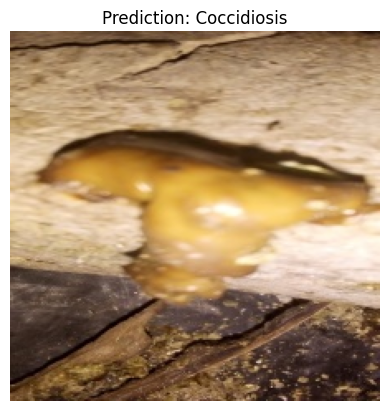

In [5]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Load the trained model
model = load_model(r'C:\End_to_End\Classification-Project\artifacts\training\model.h5')

# Load an image for prediction
img_path = r'C:\End_to_End\Classification-Project\artifacts\data_ingestion\Chicken-fecal-images\Coccidiosis\cocci.20.jpg'
img = image.load_img(img_path, target_size=(224, 224))  # use your model's input size
img_array = image.img_to_array(img)
img_array = img_array / 255.0                           # Match training preprocessing
img_array = np.expand_dims(img_array, axis=0)          # Add batch dimension

# Predict
pred = model.predict(img_array)

# Decode prediction
class_names = ['Coccidiosis', 'Healthy']  # replace with yours
predicted_class = class_names[np.argmax(pred)]

print(f"Predicted class: {predicted_class}")

# Optional: show image
plt.imshow(img)
plt.title(f"Prediction: {predicted_class}")
plt.axis('off')
plt.show()
